# 合成データを用いてフィードバックループ起因のバイアスを探る
参考: https://dl.acm.org/doi/10.1145/3308560.3317303

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
import warnings
from scipy import spatial
from tqdm import tqdm
from numpy.linalg import inv
from multiprocessing import Pool, cpu_count

np.random.seed(12345)
warnings.filterwarnings('ignore')

In [2]:
# util functions

def calculate_popularity_model(rating_df,t):
    propensity_score = []
    ratings = rating_df.values
    for i in range(ratings.shape[1]):
        propensity_score.append(float(np.count_nonzero(ratings[:,i]))/ratings.shape[0])
    propensities = np.array([propensity_score for i in range(ratings.shape[0])])
    
    temp = np.array(propensity_score)
    temp = temp.reshape((1,len(temp)))
    new_df = pd.DataFrame(temp,columns=rating_df.columns.values)
    new_df.index= ['time'+str(t)]
    return new_df

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

# ユーザーの組み合わせごとにJaccard係数を計算する
def calc_jaccard(pair, rated_items):
    u, v = pair
    intersection = len(rated_items[u].intersection(rated_items[v]))
    union = len(rated_items[u].union(rated_items[v]))
    return intersection / union

In [11]:
def Conventional_MF_random(addnum):
    
    training_error_regular = []
    testing_error_regular = []
    gini_regular = []
    bs_percentile_conv_MF = []
    jaccard_indices_regular = []
    
    topN = 20
    threshold = 0.1  ## the most popular times threshold 
    
    popularity_aggregate_regular = pd.DataFrame(columns=Data_time.columns)
    time_mask = Data_time.values<=3 ### provide the first time rating matrix
    # ユーザーの組み合わせを作成する
    user_pairs = [(u, v) for u in range(num_user) for v in range(u+1, num_user)]
    
    ## testing set
    for t in tqdm(range(1,21)):

        R_df = pd.DataFrame(Data.values*time_mask,index=Data.index,columns=Data.columns)
        rated_matrix = R_df.values
        rated_items = {u: set(np.nonzero(rated_matrix[u])[0]) for u in range(num_user)}
        
        prop_score = calculate_popularity_model(R_df,t)  
    #     ### with NMF from sklearn
        model = NMF(n_components=10, init='random', max_iter=200)
        W = model.fit_transform(R_df.values)
        H = model.components_
        pred = np.dot(W, H)
        pred_data = pd.DataFrame(pred,index=R_df.index,columns=R_df.columns)

        popularity_aggregate_regular = popularity_aggregate_regular.append(prop_score)
        t1 = prop_score.values.tolist()
        IversPropensity = []
        for i in range(Data.shape[0]):
            IversPropensity.append(t1)

        ###### calculate gini score 
        gini_score = gini(prop_score.values/np.sum(prop_score.values))
        gini_regular.append(gini_score)
#         print gini_score
#         ### error for training
        mask = R_df.values>0
        rmse= np.sqrt(np.sum(np.power(pred-R_df.values,2)*mask)/np.sum(mask))
        mae= np.sum(np.abs(pred-R_df.values)*mask)/np.sum(mask)
        training_error_regular.append([rmse,mae])

        #### select the top 10 item for each user
        #### change the mask (set cell to True which are selected to present to user)
        ## choose 10 item every time to a user
        num= addnum
        candidate_index = ~time_mask  ## convert all candidate index to True
        candidate_rating = pred_data*candidate_index ## get predicte rating on those candidate index
        sorted_ind = np.argsort(-candidate_rating,axis=1).iloc[:,:] ## get the index of each row, where top n pred are selected
        row_num = 0
        for index, row in sorted_ind.iterrows():
            ### choose random items with length of num
            lis = row.values.tolist()
#             print lis
            item_selected = np.random.choice(lis, num,replace=False)
#             print item_selected
            candidate_index[row_num,item_selected] = False  ## remove those selected item from candidate pool 
            row_num = row_num+1
        time_mask = ~candidate_index  ## get the new index 
        
        ### check result on testing set
        rmse= np.sqrt(np.sum(np.power(pred-test_df.values,2)*test_mask)/np.sum(test_mask))
        mae= np.sum(np.abs(pred-test_df.values)*test_mask)/np.sum(test_mask)
        testing_error_regular.append([rmse,mae])
        
        ### ジャッカード指数計算
        rated_matrix = R_df.values
        rated_items = {u: set(np.nonzero(rated_matrix[u])[0]) for u in range(num_user)}
        # 複数のプロセスを使ってJaccard係数を計算する
        with Pool(cpu_count()-1) as p:
            jaccard_indices = p.starmap(calc_jaccard, [(u, rated_items) for u in user_pairs])
        jaccard_indices_regular.append(np.mean(jaccard_indices))
        
    
    R_df = pd.DataFrame(Data.values*time_mask,index=Data.index,columns=Data.columns)    
        
    return training_error_regular,testing_error_regular,gini_regular,jaccard_indices_regular,R_df

In [12]:
def Conventional_MF(addnum):
    
    training_error_regular = []
    testing_error_regular = []
    gini_regular = []
    bs_percentile_conv_MF = []
    jaccard_indices_mf = []
    
    topN = 20
    threshold = 0.1  ## the most popular times threshold 

    popularity_aggregate_regular = pd.DataFrame(columns=Data_time.columns)
    time_mask = Data_time.values<=3 ### provide the first time rating matrix
    # ユーザーの組み合わせを作成する
    user_pairs = [(u, v) for u in range(num_user) for v in range(u+1, num_user)]
    
    ## testing set
    for t in tqdm(range(1,21)):
        R_df = pd.DataFrame(Data.values*time_mask,index=Data.index,columns=Data.columns)
        prop_score = calculate_popularity_model(R_df,t)  
    #     ### with NMF from sklearn
        model = NMF(n_components=10, init='random', max_iter=200)
        W = model.fit_transform(R_df.values)
        H = model.components_
        pred = np.dot(W, H)
        pred_data = pd.DataFrame(pred,index=R_df.index,columns=R_df.columns)

        ## check diversity
        #rec_ratings= get_top_n_list_for_users(W,H, R_df,topN)
        #thre = np.max(prop_score.values.tolist())*(1-threshold)
        #mean_prec, mean_recall, mean_diversity, mean_novelty = evaluate(R_df, test_df.values,topN,rec_ratings,W,H,prop_score.values.tolist(),thre)
        #diversity.append(mean_diversity)
        #novelty.append(mean_novelty)

        popularity_aggregate_regular = popularity_aggregate_regular.append(prop_score)
        t1 = prop_score.values.tolist()
        IversPropensity = []
        for i in range(Data.shape[0]):
            IversPropensity.append(t1)

        ###### calculate gini score 
        gini_score = gini(prop_score.values/np.sum(prop_score.values))
        gini_regular.append(gini_score)

#         ### error for training
        mask = R_df.values>0
        rmse= np.sqrt(np.sum(np.power(pred-R_df.values,2)*mask)/np.sum(mask))
        mae= np.sum(np.abs(pred-R_df.values)*mask)/np.sum(mask)
        training_error_regular.append([rmse,mae])

        #### select the top 10 item for each user
        #### change the mask (set cell to True which are selected to present to user)
        ## choose 10 item every time to a user
        num=addnum
        candidate_index = ~time_mask  ## convert all candidate index to True
        candidate_rating = pred_data*candidate_index ## get predicte rating on those candidate index
        sorted_ind = np.argsort(-candidate_rating,axis=1).iloc[:,:num] ## get the index of each row, where top n pred are selected

        row_num = 0
        for index, row in sorted_ind.iterrows():
            ### choose random items with length of num
            item_selected = row.values.tolist()
            candidate_index[row_num,item_selected] = False  ## remove those selected item from candidate pool 
            row_num = row_num+1
        time_mask = ~candidate_index  ## get the new index
        
        ### check result on testing set
        rmse= np.sqrt(np.sum(np.power(pred-test_df.values,2)*test_mask)/np.sum(test_mask))
        mae= np.sum(np.abs(pred-test_df.values)*test_mask)/np.sum(test_mask)
        testing_error_regular.append([rmse,mae])
        
        ### ジャッカード指数計算
        rated_matrix = R_df.values
        rated_items = {u: set(np.nonzero(rated_matrix[u])[0]) for u in range(num_user)}
        # 複数のプロセスを使ってJaccard係数を計算する
        with Pool(cpu_count()-1) as p:
            jaccard_indices = p.starmap(calc_jaccard, [(u, rated_items) for u in user_pairs])
        jaccard_indices_mf.append(np.mean(jaccard_indices))
    

    R_df = pd.DataFrame(Data.values*time_mask,index=Data.index,columns=Data.columns)
        
    return training_error_regular,testing_error_regular,gini_regular,jaccard_indices_mf,R_df
        

In [8]:
### work with synthetic data
num_user = 500
num_item = 1000
epsilon = 0.5
ratings = np.zeros((num_user,num_item))
for u in range(num_user):
    au  = np.random.normal(3.4,1,1)
    bu = np.random.normal(0.5,0.5, 1)
    for i in range(num_item):
        ti = np.random.normal(0.1,1,1)
        eij = np.random.normal(0,1,1)

        a= au+bu*ti+epsilon*eij
        ratings[u][i]= max(min(round(a[0]),5),1)

column_names=['item'+str(j) for j in range(ratings.shape[1])]
indexes = ['user'+str(i) for i in range(ratings.shape[0])]
Data = pd.DataFrame(ratings,index=indexes,columns=column_names)


Time_range = 40  ## split the ratings into 40 time range
column_names=['item'+str(j) for j in range(ratings.shape[1])]
indexes = ['user'+str(i) for i in range(ratings.shape[0])]
rated_time = np.random.randint(1,Time_range,size=(ratings.shape[0],ratings.shape[1]))
Rated_Time = pd.DataFrame(rated_time,index=indexes,columns=column_names)
Data_time = Rated_Time
       
## global pars

add_num=10

In [9]:
## get the unique testing for all different debias strateies
temp = Data_time[(27 <= Data_time) & (Data_time <= 30)]
test_mask = temp.values>0
test_df = pd.DataFrame(Data.values*test_mask,index=Data.index,columns=Data.columns)

## 

N = Data.shape[0]
M = Data.shape[1]
K=10

In [13]:
train_error_random, test_error_random, gini_random, jaccrd_indices_random, random_r_df = Conventional_MF_random(add_num)

100% 20/20 [00:58<00:00,  2.95s/it]


In [16]:
train_error_regular,test_error_regular,gini_regula, jaccrd_indices_mf, mf_r_df = Conventional_MF(add_num)

100% 20/20 [00:58<00:00,  2.90s/it]


In [21]:
random_r_df.values.sum()

414273.0

In [ ]:
import sys;sys.path.append('..')
from util.plot import plot_heatmap

plot_heatmap(ratings)

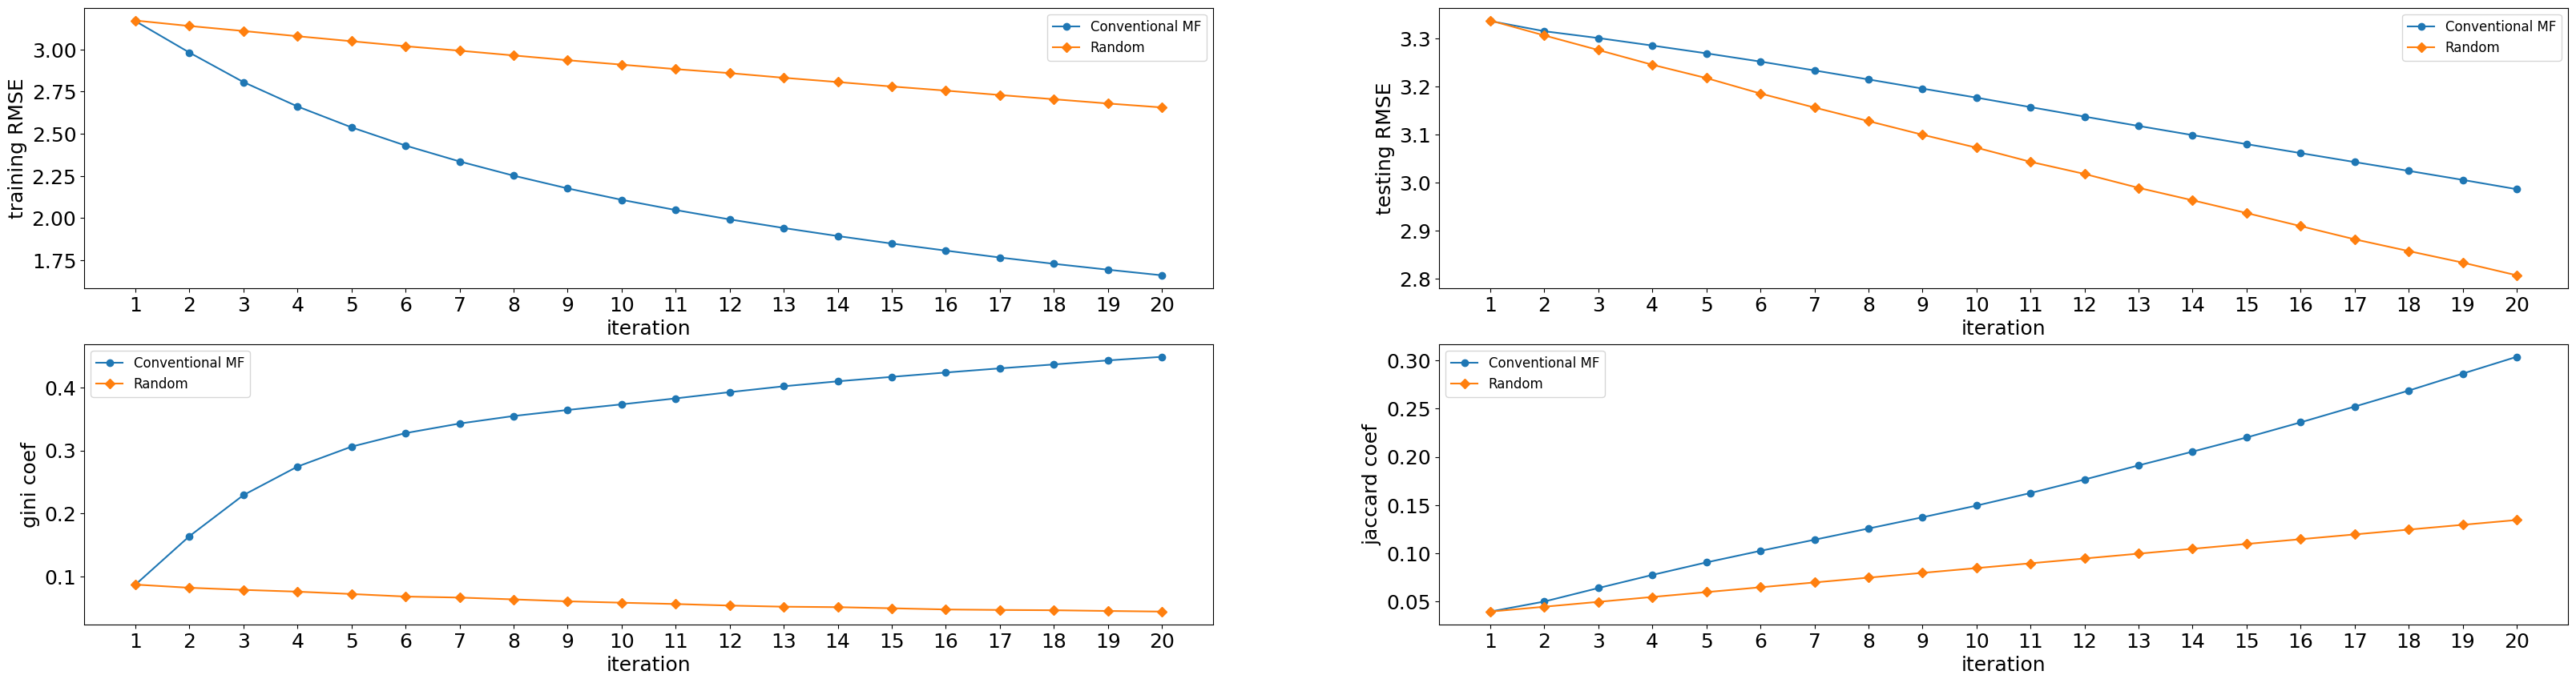

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40, 10))

axes[0,0].plot(np.array(train_error_regular)[:,0], label='Conventional MF', marker='o')
axes[0,0].plot(np.array(train_error_random)[:,0], label='Random', marker='D')
axes[0,0].legend(fontsize=12)
axes[0,0].set_xlabel('iteration', fontsize=18)
axes[0,0].set_ylabel('training RMSE', fontsize=18)
axes[0,0].set_xticks(range(0, 20))
axes[0,0].set_xticklabels([str(i+1) for i in range(0,20)], fontsize=18)
axes[0,0].tick_params(axis='y', labelsize=18)

axes[0,1].plot(np.array(test_error_regular)[:,0], label='Conventional MF', marker='o')
axes[0,1].plot(np.array(test_error_random)[:,0], label='Random', marker='D')
axes[0,1].legend(fontsize=12)
axes[0,1].set_xlabel('iteration', fontsize=18)
axes[0,1].set_ylabel('testing RMSE', fontsize=18)
axes[0,1].set_xticks(range(0, 20))
axes[0,1].set_xticklabels([str(i+1) for i in range(0,20)], fontsize=18)
axes[0,1].tick_params(axis='y', labelsize=18)

axes[1,0].plot(np.array(gini_regula), label='Conventional MF', marker='o')
axes[1,0].plot(np.array(gini_random), label='Random', marker='D')
axes[1,0].legend(fontsize=12)
axes[1,0].set_xlabel('iteration', fontsize=18)
axes[1,0].set_ylabel('gini coef', fontsize=18)
axes[1,0].set_xticks(range(0, 20))
axes[1,0].set_xticklabels([str(i+1) for i in range(0,20)], fontsize=18)
axes[1,0].tick_params(axis='y', labelsize=18)

axes[1,1].plot(np.array(jaccrd_indices_mf), label='Conventional MF', marker='o')
axes[1,1].plot(np.array(jaccrd_indices_random), label='Random', marker='D')
axes[1,1].legend(fontsize=12)
axes[1,1].set_xlabel('iteration', fontsize=18)
axes[1,1].set_ylabel('jaccard coef', fontsize=18)
axes[1,1].set_xticks(range(0, 20))
axes[1,1].set_xticklabels([str(i+1) for i in range(0,20)], fontsize=18)
axes[1,1].tick_params(axis='y', labelsize=18)

plt.show()

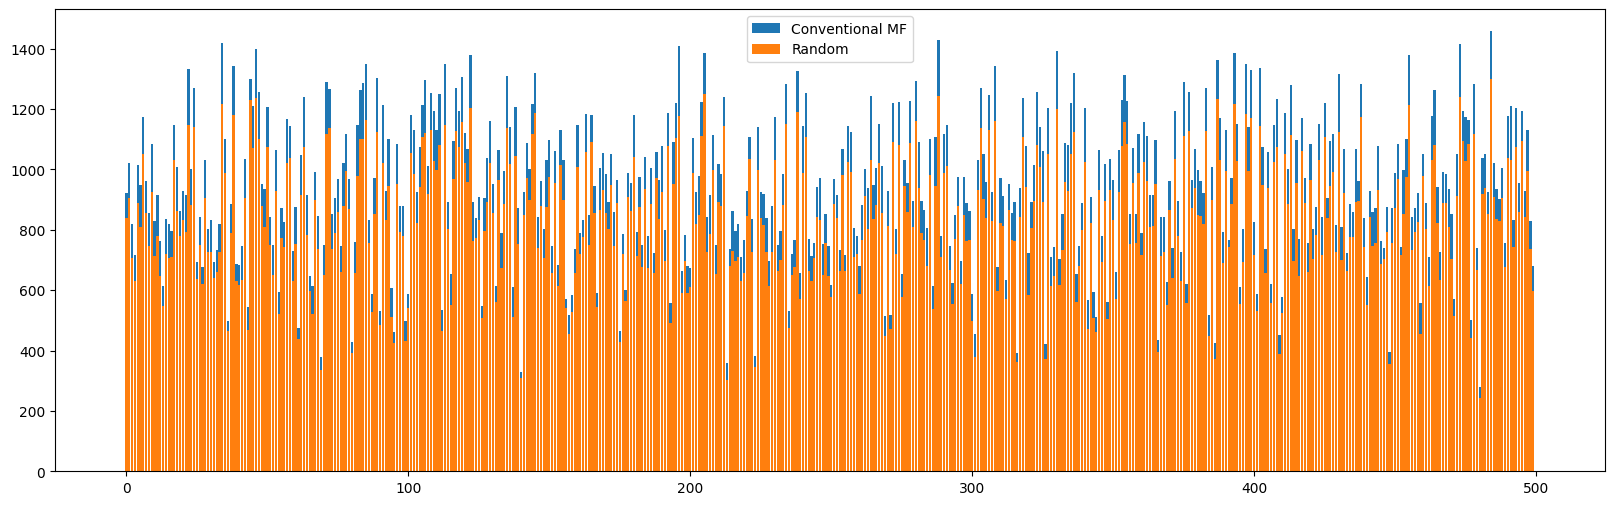

In [60]:
user_utils_mf = mf_r_df.values.sum(1)
user_utils_random = random_r_df.values.sum(1)
users = [u for u in range(num_user)]

plt.figure(figsize=(20,6))
plt.bar(users, user_utils_mf, label='Conventional MF')
plt.bar(users, user_utils_random, label="Random")
plt.legend()

plt.show()

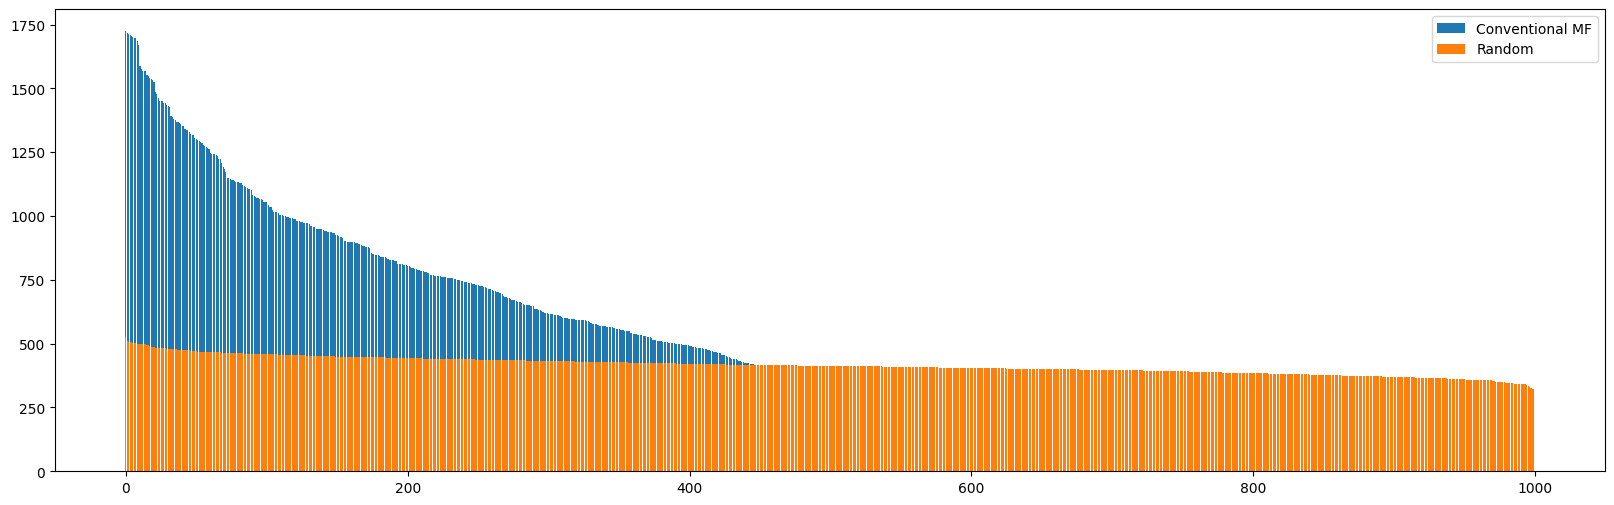

In [71]:
mf_item_utils = mf_r_df.values.sum(0)
mf_item_utils = np.sort(mf_item_utils)[::-1]
random_item_utils = random_r_df.values.sum(0)
random_item_utils = np.sort(random_item_utils)[::-1]
items = [i for i in range(num_item)]

plt.figure(figsize=(20,6))
plt.bar(items, mf_item_utils, label='Conventional MF')
plt.bar(items, random_item_utils, label="Random")
plt.legend()

plt.show()